<a href="https://colab.research.google.com/github/GRACOPORDEUS/atividades_mestrado/blob/main/1107106_220511_lista2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 1ª Questão

"que tipo de pessoa tem mais probabilidade de sobreviver?"

### data manipulation

#### import from kaggle

In [26]:
!pip install kaggle

In [27]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [28]:
! cp kaggle.json ~/.kaggle/

In [29]:
! chmod 600 ~/.kaggle/kaggle.json

In [30]:
! kaggle competitions download -c titanic --force

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 35.2MB/s]


In [31]:
! unzip titanic.zip

Archive:  titanic.zip
replace gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#### data preprocessing

In [345]:
titanic_train = pd.read_csv("train.csv")
titanic_test = pd.read_csv("test.csv")

Train

In [343]:
titanic_train.drop(['Name','Ticket','Cabin'],axis=1,inplace=True)
y = titanic_train.loc[:, 'Survived'].values

sex = pd.get_dummies(titanic_train['Sex'],drop_first=True)
embark = pd.get_dummies(titanic_train['Embarked'],drop_first=True)

titanic_train = pd.concat([titanic_train,sex,embark],axis=1)

titanic_train.drop(['Sex','Embarked'],axis=1,inplace=True)

titanic_train.fillna(titanic_train.mean(),inplace=True)

train_columns = titanic_train.columns
titanic_train = pd.DataFrame(StandardScaler().fit_transform(titanic_train))
titanic_train.columns  = train_columns

features = titanic_train.iloc[:,2:].columns.tolist()
target   = titanic_train.loc[:, 'Survived'].name

X = titanic_train.iloc[:,2:].values

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [82]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((712, 8), (712,), (179, 8), (179,))

Test

In [346]:
titanic_test.drop(['Name','Ticket','Cabin'],axis=1,inplace=True)

sex = pd.get_dummies(titanic_test['Sex'],drop_first=True)
embark = pd.get_dummies(titanic_test['Embarked'],drop_first=True)

titanic_test = pd.concat([titanic_test,sex,embark],axis=1)

titanic_test.drop(['Sex','Embarked'],axis=1,inplace=True)

titanic_test.fillna(titanic_test.mean(),inplace=True)

test_columns  = titanic_test.columns
titanic_test = pd.DataFrame(StandardScaler().fit_transform(titanic_test))
titanic_test.columns  = test_columns

In [347]:
test = titanic_test.iloc[:,1:].values

In [349]:
test.shape

(418, 8)

### Network

In [318]:
class dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y)
        self.n_sample = x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_sample

In [261]:
train_dataset = dataset(X_train, y_train)
test_dataset = dataset(X_test, y_test)

In [262]:
# datasset parameters
input_size = X_train.shape[1]
batch_size = X_train.shape[0]
num_classes = 2

In [263]:
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = True)

In [400]:
class NN(nn.Module):
  def __init__(self, input_size, num_classes, tx_dropout):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(input_size, int(input_size*2))
    self.fc2 = nn.Linear(int(input_size*2), int(input_size*3))
    self.fc3 = nn.Linear(int(input_size*3), int(input_size*4))
    self.fc4 = nn.Linear(int(input_size*4), int(input_size*3))
    self.fc5 = nn.Linear(int(input_size*3), int(input_size*2))
    self.fc6 = nn.Linear(int(input_size*2), int(input_size*1))
    self.fc7 = nn.Linear(int(input_size*1), num_classes)
    
    self.dropout = nn.Dropout(tx_dropout)

    self.bn1 = nn.BatchNorm1d(int(input_size*1))
    self.bn2 = nn.BatchNorm1d(int(input_size*2))
    self.bn3 = nn.BatchNorm1d(int(input_size*3))
    self.bn4 = nn.BatchNorm1d(int(input_size*4))
  
  def forward(self, x):
    x = F.relu(self.bn2(self.fc1(x)))
    x = self.dropout(F.relu(self.bn3(self.fc2(x))))
    x = self.dropout(F.relu(self.bn4(self.fc3(x))))
    x = self.dropout(F.relu(self.bn3(self.fc4(x))))
    x = self.dropout(F.relu(self.bn2(self.fc5(x))))
    x = self.dropout(F.relu(self.bn1(self.fc6(x))))
    x = F.relu(self.fc7(x))
    x = torch.sigmoid(x)
    return x

In [ ]:
nn.Linear()

In [401]:
print(NN(input_size, num_classes, tx_dropout= 0))

NN(
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=24, bias=True)
  (fc3): Linear(in_features=24, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=24, bias=True)
  (fc5): Linear(in_features=24, out_features=16, bias=True)
  (fc6): Linear(in_features=16, out_features=8, bias=True)
  (fc7): Linear(in_features=8, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [380]:
# Check accuracy on training & test to see how good our model
def valdation_metrics(loader, test_losses, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            outputs = model(x)
            _, predictions = outputs.max(1)

            # accuracy
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            accuracy = num_correct/num_samples

            # validation losses
            loss = criterion(outputs, y)
            test_losses += loss.item() 
            test_losses = (test_losses/num_samples)
            
    model.train()
    return accuracy, test_losses

In [381]:
# ploting evaluations
def network_plots(train, test, metric):
  fig, ax = plt.subplots(figsize=(8,5))

  ax.plot(train)
  ax.plot(test)

  ax.legend(('Train', 'Test'), loc="best")
  plt.show()
  print(f"The {metric} in train was {round(train[-1],2)}% and in test was {round(test[-1],2)}%.")

In [411]:
# hiperparameters
num_epochs = 1000
learning_rate = 0.0001
tx_dropout = 0.3

# Initialize network
model = NN(
    input_size=input_size, 
    num_classes=num_classes, 
    tx_dropout=tx_dropout
    ).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network
plot_train_losses = []
plot_test_losses = []
plot_train_accuracy = []
plot_test_accuracy = []

for epoch in tqdm(range(num_epochs)):
    train_losses = 0.0
    test_losses = 0.0
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Get to correct shape
        data = data.reshape(data.shape[0], -1)

        # forward
        outputs = model(data)
        loss = criterion(outputs, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    

    # metrics
    train_metric = valdation_metrics(train_loader, train_losses, model)
    test_metric = valdation_metrics(test_loader, test_losses, model)

    # cumulative losses
    train_losses = train_metric[1]*100
    plot_train_losses.append(train_losses)
    test_losses = test_metric[1]*100
    plot_test_losses.append(test_losses)
    
    # cumulative accuracy
    train_accuracy = (train_metric[0]*100).item()
    test_accuracy = (test_metric[0]*100).item()
    
    plot_train_accuracy.append(train_accuracy)
    plot_test_accuracy.append(test_accuracy)

100%|██████████| 1000/1000 [00:17<00:00, 57.72it/s]


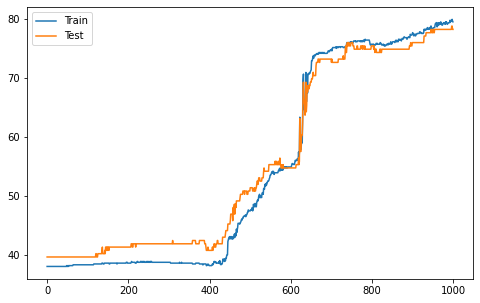

The Accuracy in train was 79.49% and in test was 78.21%.


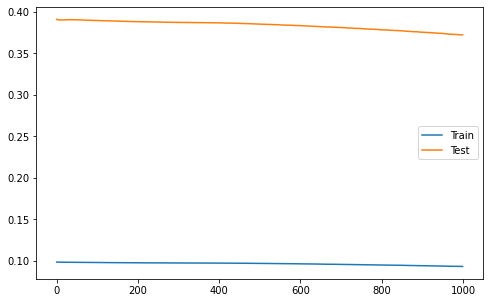

The Losses in train was 0.09% and in test was 0.37%.


In [412]:
network_plots(plot_train_accuracy, plot_test_accuracy, 'Accuracy')
network_plots(plot_train_losses, plot_test_losses, 'Losses')

Submission

In [408]:
class submission(Dataset):
    def __init__(self, x):
        self.x = torch.from_numpy(x).float()
        self.n_sample = x.shape[0]

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.n_sample


sub_dataset = submission(test)
sub_loader = DataLoader(
    dataset = sub_dataset,
    batch_size = test.shape[0],
    shuffle=True)


with torch.no_grad():
    for x in sub_loader:
        x = x.to(device=device)
        x = x.reshape(x.shape[0], -1)
        test_result = model(x)


values, labels = torch.max(test_result, 1)
survived = labels.data.numpy()

df_sub = pd.read_csv("gender_submission.csv")
submission = pd.DataFrame({'PassengerId': df_sub['PassengerId'], 'Survived': survived})
submission.to_csv('submission.csv', index=False)
! kaggle competitions submit -c titanic -f submission.csv -m "No mensage."

100% 2.77k/2.77k [00:01<00:00, 1.50kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

Score: 0.56459

# 2ª Questão